<a href="https://colab.research.google.com/github/Ash-0154/Financial-Report-SEC-10K-filing-Q-A-System/blob/main/Financial_Reports_Q%26ASystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🧾 SEC 10-K Financial Report QA System**

---




### This project allows users to ask intelligent questions from **SEC 10-K filings** (like AAPL, AMZN, etc.) using a hybrid **Retrieval-Augmented Generation (RAG)** system. It integrates:

### - 🔍 Retrieval-Augmented Generation (RAG) : FAISS + BM25 retrieval
### - 🧠 Mistral-7B-Instruct-v0.1(quantized for speed)
### - 🧾 Real 10-K filings via SEC API
### - 💬 Interactive UI via Gradio

### This is a fully working **QA pipeline on financial reports** built end-to-end in Google Colab.

In [1]:
!pip install -U sec-api beautifulsoup4 sentence-transformers lxml faiss-cpu transformers accelerate bitsandbytes rank_bm25 gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7

###**🔧 Step 1: Download SEC 10-K Filings Using sec-api**

We use the [sec-api](https://sec-api.io) to programmatically fetch 10-K filings for selected companies (e.g., AAPL, AMZN, META). Each document is saved as an `.html` file in a `filings/` directory for further processing.


In [2]:
from sec_api import QueryApi, RenderApi
import os

api_key = "99dc2a5072331bc9003c2c5f5a597450a5422262e11912459d7ead87af9ca43c"

queryApi = QueryApi(api_key=api_key)
renderApi = RenderApi(api_key=api_key)

companies = ["AAPL", "AMZN","META"]
os.makedirs("filings", exist_ok=True)

for ticker in companies:
    query = {
        "query": f"ticker:{ticker} AND formType:\"10-K\"",
        "from": "0",
        "size": "3",  # Get 3 most recent per company
        "sort": [{ "filedAt": { "order": "desc" } }]
    }
    filings = queryApi.get_filings(query)
    for filing in filings['filings']:
        filing_url = filing['linkToFilingDetails']
        filing_date = filing['filedAt'][:10]  # e.g., '2023-10-27'
        html = renderApi.get_filing(filing_url)
        filename = f"{ticker}_10-K_{filing_date}.html"
        filepath = os.path.join("filings", filename)
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(html)
        print(f"Saved: {filepath}")


Saved: filings/AAPL_10-K_2024-11-01.html
Saved: filings/AAPL_10-K_2023-11-02.html
Saved: filings/AAPL_10-K_2022-10-27.html
Saved: filings/AMZN_10-K_2025-02-06.html
Saved: filings/AMZN_10-K_2024-02-01.html
Saved: filings/AMZN_10-K_2023-02-02.html
Saved: filings/META_10-K_2025-01-29.html
Saved: filings/META_10-K_2024-02-01.html
Saved: filings/META_10-K_2023-02-01.html


###**🧹 Step 2: Parse and Clean HTML Files**

Each 10-K filing is parsed using `BeautifulSoup`. We:
- Remove HTML tags, scripts, headers, etc.
- Clean formatting, normalize special characters.
- Extract structured sections like "Item 1A", "Item 7", etc.
- Store the result in a dictionary for later embedding.

This step prepares the data for chunking and embedding.


In [3]:
import os
import re
from bs4 import BeautifulSoup
import unicodedata

def clean_text(text):
    text = unicodedata.normalize('NFKD', text)
    text = re.sub(r'[\u00A0\u2000-\u200B\u202F\u205F\u3000]', ' ', text)
    text = text.replace('�', '')
    text = text.replace('“', '"').replace('”', '"').replace('’', "'").replace('‘', "'")
    text = text.replace('–', '-').replace('—', '-')
    text = re.sub(r'[ \t]+', ' ', text)
    text = re.sub(r'\n+', '\n', text)
    return text.strip()

def parse_and_clean_10k_html(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "lxml")
    for tag in soup(["script", "style", "header", "footer", "nav", "form", "input", "button"]):
        tag.decompose()
    for comment in soup.find_all(string=lambda text: isinstance(text, type(soup.Comment))):
        comment.extract()
    for br in soup.find_all("br"):
        br.replace_with("\n")
    for p in soup.find_all("p"):
        p.insert_after("\n")
    for div in soup.find_all("div"):
        div.insert_after("\n")
    text = soup.get_text(separator="\n")
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    clean_text_block = "\n".join(lines)
    section_pattern = re.compile(r"(Item\s*\d+[A-Z]?(?:\.|\:|–|-)?\s*[^\n]{0,100})", flags=re.IGNORECASE)
    matches = list(section_pattern.finditer(clean_text_block))
    real_sections = []
    for m in matches:
        if len(m.group(0)) > 20 or not re.search(r'\d{1,2}\s*$', m.group(0)):
            real_sections.append(m)
    if not real_sections:
        real_sections = matches
    section_dict = {}
    for idx, match in enumerate(real_sections):
        start = match.start()
        end = real_sections[idx + 1].start() if idx + 1 < len(real_sections) else len(clean_text_block)
        header = re.sub(r'\s+', ' ', match.group(0)).strip().title()
        content = clean_text_block[start:end].strip()
        if content.lower().startswith(header.lower()):
            content = content[len(header):].strip()
        content = clean_text(content)
        section_dict[header] = content
    return section_dict


filings_folder = '/content/filings'
all_filings = {}
for filename in os.listdir(filings_folder):
    if filename.endswith(".html"):
        path = os.path.join(filings_folder, filename)
        sections = parse_and_clean_10k_html(path)
        all_filings[filename] = sections

print("Parsing complete. Number of filings:", len(all_filings))


/tmp/ipython-input-3-275878042.py:18: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(f, "lxml")


Parsing complete. Number of filings: 9


###**🧩 Step 3: Chunking and Embedding**

In this section, the extracted 10-K filings are split into smaller, meaningful chunks and then encoded into dense vector representations using a pretrained Sentence-BERT model.

To begin, each section from the 10-K filings that matches patterns like "Item 1A", "Item 7", etc., is processed. These are typically key sections such as "Risk Factors" and "Management’s Discussion and Analysis". The content of each such section is broken into chunks of up to three paragraphs, with a one-paragraph overlap between consecutive chunks. This helps preserve continuity and ensure each chunk retains context.

For every chunk generated, metadata is stored including the source filename, section title, chunk ID, and the actual chunk text. These chunks are then passed through a `SentenceTransformer` model (`all-MiniLM-L6-v2`) which generates vector embeddings capturing the semantic meaning of the text. These embeddings are used later for semantic search using FAISS.

The generated chunks and embeddings are serialized and saved to a file named `chunks_and_embeddings.pkl`. This allows for quick reuse in later steps without having to recompute embeddings.

After execution, the output will indicate how many chunks were prepared and confirm that the data has been saved successfully.




In [4]:
import pickle
from sentence_transformers import SentenceTransformer

def chunk_paragraphs(text, max_paragraphs=3, overlap=1):
    paras = [p for p in text.split('\n') if p.strip()]
    chunks = []
    for i in range(0, len(paras), max_paragraphs - overlap):
        chunk = '\n'.join(paras[i:i+max_paragraphs])
        if chunk:
            chunks.append(chunk)
    return chunks

main_section_pattern = re.compile(r"^Item\s*\d+[A-Z]?(?:\.|\:|–|-)?\s", re.IGNORECASE)
all_chunks = []
for filename, sections in all_filings.items():
    for section_header, section_text in sections.items():
        if main_section_pattern.match(section_header):
            chunks = chunk_paragraphs(section_text, max_paragraphs=3, overlap=1)
            for idx, chunk in enumerate(chunks):
                all_chunks.append({
                    'filename': filename,
                    'section': section_header,
                    'chunk_id': idx,
                    'text': chunk
                })

print(f"Total chunks prepared: {len(all_chunks)}")

model = SentenceTransformer('all-MiniLM-L6-v2')
texts = [chunk['text'] for chunk in all_chunks]
print("Generating embeddings...")
embeddings = model.encode(texts, show_progress_bar=True)

with open("chunks_and_embeddings.pkl", "wb") as f:
    pickle.dump({'chunks': all_chunks, 'embeddings': embeddings}, f)

print("Chunking and embedding complete! Data saved to chunks_and_embeddings.pkl")



Total chunks prepared: 19015


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings...


Batches:   0%|          | 0/595 [00:00<?, ?it/s]

Chunking and embedding complete! Data saved to chunks_and_embeddings.pkl


In [5]:
import pickle

with open("chunks_and_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

all_chunks = data['chunks']
embeddings = data['embeddings']


We also prepare for **hybrid search** using:
- FAISS (vector search)
- BM25 (sparse token-based search)

In [6]:
import faiss
import numpy as np

embeddings = np.array(embeddings).astype("float32")  # Ensure correct dtype
index = faiss.IndexFlatL2(embeddings.shape[1])       # L2 distance index
index.add(embeddings)


In [7]:
from rank_bm25 import BM25Okapi

# Tokenize all chunk texts for BM25
tokenized_corpus = [chunk['text'].split() for chunk in all_chunks]
bm25 = BM25Okapi(tokenized_corpus)


In [8]:
from huggingface_hub import login
login()


###🧠 **Step 4:Loading Mistral-7B-Instruct with 4-bit Quantization**

We load the [Mistral-7B-Instruct-v0.1](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1) model using Hugging Face Transformers. To reduce memory usage and enable inference on a single GPU (like Google Colab’s T4 or A100), we apply **4-bit quantization** using `BitsAndBytes` from `transformers`.

###🔧 Configuration Summary

- **Model**: `mistralai/Mistral-7B-Instruct-v0.1`  
  A state-of-the-art open-weight 7B parameter instruction-tuned LLM.
  
- **Quantization Strategy**:
  - `load_in_4bit=True`: Loads model weights in 4-bit precision
  - `bnb_4bit_use_double_quant=True`: Applies second quantization layer for better compression
  - `bnb_4bit_quant_type="nf4"`: Uses NormalFloat4, optimized for language models
  - `bnb_4bit_compute_dtype=torch.bfloat16`: Keeps computations in bfloat16 for speed and stability

- **Device Mapping**: `device_map='auto'` ensures automatic distribution to GPU if available

This allows running large models like Mistral-7B efficiently even on limited hardware.


In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### 🔍**Step 5:Hybrid Search using BM25 + Semantic Similarity**

To accurately retrieve the most relevant sections from 10-K filings, we implement a **hybrid search** that combines:

- **BM25** (lexical retrieval): Finds passages with overlapping keywords.
- **SentenceTransformer Embeddings**: Captures deeper semantic similarity between the query and document chunks.

### 📚 Components Used

- `BM25Okapi` (from `rank_bm25`): Traditional keyword-based retrieval.
- `all-MiniLM-L6-v2` model (from `sentence-transformers`): Converts text into dense embeddings.
- `cosine similarity` (via `util.cos_sim`) to re-rank candidate chunks.

### ⚙️ Key Functions

- `expand_query(query)`:  
  Adds domain-specific synonyms for better recall. For example, the query `"risk"` also searches for `"risk factors"`, `"potential risks"`, and `"threats"`.

- `hybrid_search(...)`:  
  1. Computes **BM25 scores** on tokenized chunks.  
  2. Performs **FAISS ANN search** using pre-computed embeddings.  
  3. Combines top results from both methods.  
  4. Filters results by `company` and `year` if specified.  
  5. Reranks candidates using **cosine similarity** with the query embedding.

- `hybrid_search_with_expansion(...)`:  
  Runs `hybrid_search` on the query and its expanded forms. Deduplicates results and limits output to `top_k` chunks.

This ensures more robust and context-aware document retrieval, which is crucial for accurate QA over lengthy 10-K reports.


In [11]:
from rank_bm25 import BM25Okapi
from sentence_transformers import util
import torch

tokenized_corpus = [chunk['text'].split() for chunk in all_chunks]
bm25 = BM25Okapi(tokenized_corpus)
embedder = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

def expand_query(query):
    expansions = [query]
    if "risk" in query.lower():
        expansions += ["risk factors", "potential risks", "threats"]
    return expansions

def hybrid_search(query, top_k=5, company=None, year=None):
    bm25_scores = bm25.get_scores(query.split())
    bm25_top_indices = np.argsort(bm25_scores)[::-1][:top_k*2]
    query_vec = embedder.encode([query]).astype("float32")
    D, I = index.search(query_vec, top_k*2)
    faiss_top_indices = I[0]
    all_indices = list(set(bm25_top_indices).union(set(faiss_top_indices)))
    candidates = []
    candidate_embeddings = []
    for idx in all_indices:
        chunk = all_chunks[idx]
        if company and not chunk['filename'].startswith(company):
            continue
        if year and year not in chunk['filename']:
            continue
        candidates.append(chunk)
        candidate_embeddings.append(embeddings[idx])
        if len(candidates) >= top_k*4:
            break
    if not candidates:
        return []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    query_embedding = embedder.encode([query], convert_to_tensor=True).to(device)
    chunk_embeddings_tensor = torch.from_numpy(np.array(candidate_embeddings)).to(device)
    cos_scores = util.cos_sim(query_embedding, chunk_embeddings_tensor)[0]
    top_results = np.argsort(-cos_scores.cpu().numpy())[:top_k]
    reranked_chunks = [candidates[i] for i in top_results]
    return reranked_chunks

def hybrid_search_with_expansion(query, top_k=5, company=None, year=None):
    queries = expand_query(query)
    all_results = []
    for q in queries:
        all_results.extend(hybrid_search(q, top_k=top_k, company=company, year=year))
    seen = set()
    unique_results = []
    for c in all_results:
        key = (c['filename'], c['section'], c['chunk_id'])
        if key not in seen:
            unique_results.append(c)
            seen.add(key)
        if len(unique_results) >= top_k:
            break
    return unique_results



In [12]:
def assemble_context(chunks, tokenizer, max_tokens=3584):
    context = ""
    total_tokens = 0
    for c in chunks:
        chunk_text = c['text']
        chunk_tokens = len(tokenizer(chunk_text, return_tensors="pt")["input_ids"][0])
        if total_tokens + chunk_tokens > max_tokens:
            break
        context += chunk_text + "\n\n"
        total_tokens += chunk_tokens
    return context


### 🧠 **Step 6: Prompt Construction & Mistral Response Generation**

This section defines how the Mistral model is prompted to answer questions based on the retrieved context.

### 🧾 `construct_prompt(...)`

This function dynamically builds the input prompt for the language model based on the query and the retrieved document chunk.

Supported styles:

- **`default`**:  
  Asks the model to answer the question strictly based on the context without section headers or navigation noise.

- **`extract_bullets`**:  
  Prompts the model to extract specific facts (e.g., risk-related information) as **clean, bullet-pointed items**, excluding general or structural text like "Item 1A".

- **`summarize`**:  
  Requests a concise **summary** of the key ideas from the given context.

- **`kpi_extract`**:  
  Extracts **Key Performance Indicators (KPIs)** and lists them as bullet points.

This flexibility allows the same model to be used for a variety of financial NLP tasks like fact extraction, summarization, or data point retrieval.



### 🚀 `ask_mistral(...)`

This function takes a **question and context**, creates a prompt using `construct_prompt`, and sends it to the **Mistral 7B Instruct model** for generation.

Key Parameters:

- `question`: The user’s query.
- `context`: The text chunk (retrieved from hybrid search) to condition the model.
- `max_new_tokens`: Controls the length of the generated answer.
- `prompt_style`: Specifies the behavior of the prompt (`default`, `summarize`, etc.).

The generation uses **greedy decoding** (`temperature=0.0`, `top_p=1.0`, `do_sample=False`) to ensure deterministic and factual responses.

The final answer is stripped of the prompt to cleanly return only the relevant output.

This modular design supports diverse use cases in 10-K QA—from factual answers to summaries and KPI lists.


In [13]:
def construct_prompt(context, question, style='default'):
    if style == 'default':
        prompt = f"Context:\n{context}\n\nQuestion:\n{question}\n\nAnswer (do not include section headers or navigation lines):"
    elif style == 'extract_bullets':
      prompt = (
        f"Context:\n{context}\n\n"
        "Question:\nList all specific risk-related facts mentioned in the context above. "
        "Do NOT include section headers, titles like 'Item 1A', or general statements. "
        "Only extract clear factual statements as separate bullet points."
    )

    elif style == 'summarize':
        prompt = (
            f"Context:\n{context}\n\nQuestion:\n{question}\n\n"
            "Please provide a concise summary of the key points from the context above. Do not include section headers."
        )
    elif style == 'kpi_extract':
        prompt = (
            f"Context:\n{context}\n\n"
            "Question:\nExtract all key performance indicators (KPIs) mentioned in the context above. "
            "List each KPI as a bullet point. Do not include section headers or navigation lines."
        )
    else:
        prompt = f"Context:\n{context}\n\nQuestion:\n{question}\n\nAnswer:"
    return prompt



def ask_mistral(question, context=None, max_new_tokens=512, prompt_style='default'):
    prompt = construct_prompt(context, question, style=prompt_style)
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device) # Use the Mistral model device
    with torch.no_grad():
        outputs = model.generate( # Use the Mistral model for generation
            **input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
            top_p=1.0,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.replace(prompt, "").strip()

### ✅ **Post-processing: Deduplication Utilities**

After generating answers with the LLM, especially in list or bullet formats, some lines may be **redundant**. These utility functions help clean the output by removing repeated lines, ensuring clarity and precision in the final response.

### 🔹 `deduplicate_bullets(answer_text)`
- Designed specifically for bullet-pointed outputs (e.g., from the `extract_bullets` or `kpi_extract` styles).
- Strips each line, converts to lowercase for **case-insensitive deduplication**, and returns a cleaned list of unique bullets.

### 🔹 `deduplicate_sentences(answer_text)`
- Works on sentence-based answers (like in `default` or `summarize` styles).
- Keeps only **first occurrences** of each sentence to avoid repetition.

### 🔹 `deduplicate_kpi(answer_text)`
- Tailored for KPI extractions where each line represents a performance metric.
- Removes duplicate KPI lines, even if the list is semi-structured or lacks bullet formatting.


These functions improve readability and prevent inflation of content by repeated facts or phrases.


In [14]:
def deduplicate_bullets(answer_text):
    seen = set()
    unique_bullets = []
    for line in answer_text.split('\n'):
        bullet = line.strip()
        norm = bullet.lower()
        if bullet and norm not in seen:
            unique_bullets.append(bullet)
            seen.add(norm)
    return '\n'.join(unique_bullets)


def deduplicate_sentences(answer_text):
    seen = set()
    unique_sentences = []
    for line in answer_text.split('\n'):
        sent = line.strip()
        if sent and sent not in seen:
            unique_sentences.append(sent)
            seen.add(sent)
    return '\n'.join(unique_sentences)

def deduplicate_kpi(answer_text):
    """
    Deduplicate KPI lines from a free-form or bullet-style answer.
    Each line is treated as a distinct KPI statement.
    """
    seen = set()
    unique_lines = []
    for line in answer_text.split('\n'):
        clean_line = line.strip()
        if clean_line and clean_line not in seen:
            unique_lines.append(clean_line)
            seen.add(clean_line)
    return '\n'.join(unique_lines)




In [15]:
import re

def filter_section_headers(bullets):
    """
    Remove lines that are just section headers or generic section names.
    """
    filtered = []
    for b in bullets.split('\n'):
        b_strip = b.strip()
        # Regex matches "Item 1A", "Section 2", "Part I", etc.
        if not re.match(r'^(Item\s*\d+[A-Z]?\.?|Section\s*\d+|Part\s+[IVXLC]+\.?)', b_strip, re.IGNORECASE) and len(b_strip) > 0:
            filtered.append(b_strip)
    return '\n'.join(filtered)


### ✅**Step 7: RAG-Based Question Answering: `rag_qa()`**

This is the **main function** that performs **Retrieval-Augmented Generation (RAG)** on 10-K filings. It integrates chunk retrieval, prompt generation, and response generation using the Mistral LLM.

### 🔧 Function: `rag_qa(query, top_k=5, company=None, year=None, show_sources=False, prompt_style='default')`

### 🔹 Step-by-Step Breakdown:

1. **Hybrid Retrieval with Expansion**:
   - Uses both **BM25** and **FAISS vector search** via `hybrid_search_with_expansion()` to fetch relevant chunks.
   - Expands the query with related phrases (e.g., “risk” → “risk factors”, “potential risks”, etc.) to improve recall.

2. **Context Assembly**:
   - Selected chunks are passed to `assemble_context()` to build a single context block (up to ~3500 tokens) for the LLM prompt.

3. **Query Answering via Mistral**:
   - Calls `ask_mistral()` to get an answer from the Mistral-7B model using the selected context.
   - The format of the prompt is determined by the `prompt_style` parameter:
     - `'default'` → direct Q&A
     - `'extract_bullets'` → bullet-point extraction of factual information
     - `'summarize'` → concise summaries
     - `'kpi_extract'` → extracts KPIs

4. **Post-Processing**:
   - Applies deduplication based on the selected `prompt_style`:
     - Removes repeated bullets, sentences, or KPIs
     - Filters out unwanted section headers (e.g., "Item 1A") if extracting bullets

5. **Source Snippet Collection**:
   - Prepares a **Pandas DataFrame** with the metadata of retrieved context chunks:
     - `Filename`, `Section`, `Chunk ID`, and a preview (`Text`)
   - Useful for displaying sources in a Gradio or notebook UI if `show_sources=True`.

### ✅ Returns:
- `answer`: Final cleaned response generated by the LLM.
- `snippets_df`: A DataFrame of retrieved chunk metadata, useful for showing sources or justifying the answer.


In [16]:
def rag_qa(query, top_k=5, company=None, year=None, show_sources=False, prompt_style='default'):
    results = hybrid_search_with_expansion(query, top_k=top_k, company=company, year=year)
    context = assemble_context(results, tokenizer, max_tokens=3584)
    answer = ask_mistral(query, context=context, prompt_style=prompt_style, max_new_tokens=512)
    if prompt_style == 'extract_bullets':
        answer = deduplicate_bullets(answer)
        answer = filter_section_headers(answer)
    elif prompt_style in ['default', 'summarize']:
        answer = deduplicate_sentences(answer)
    elif prompt_style == 'kpi_extract':
        answer = deduplicate_kpi(answer)
    snippet_rows = []
    for c in results:
        snippet_rows.append({
            "Filename": c['filename'],
            "Section": c['section'],
            "Chunk ID": c['chunk_id'],
            "Text": c['text'][:200] + ("..." if len(c['text']) > 200 else "")
        })
    snippets_df = pd.DataFrame(snippet_rows)
    return answer, snippets_df


### 🧠**Step 8: RAG with Sliding Window: Scalable Retrieval-Augmented Generation**

When a user query matches a large number of relevant chunks (e.g., more than 5), combining all those chunks into a single prompt would exceed the token limits of the LLM. To solve this, we apply a **sliding window approach** that breaks the matched chunks into manageable windows of context, and performs inference separately on each.

The `sliding_windows()` function builds windows of chunks such that the total token count of each window does not exceed a configurable limit (`max_tokens`, default: 3584). Consecutive windows can overlap slightly (default: 1 chunk) to preserve continuity of context.

The `rag_qa_sliding_window()` function performs hybrid retrieval as usual but applies the sliding window logic if the result set is large. It processes each window individually using the `ask_mistral()` function. Depending on the `prompt_style`, it collects and deduplicates results across all windows:

- **`extract_bullets`**: collects unique bullet points
- **`default` / `summarize`**: collects unique sentences
- **`kpi_extract`**: collects unique KPI mentions

This method ensures scalability by respecting token limits while aggregating responses from multiple windows into a single final answer.

The function returns:
- A **combined, deduplicated answer**
- A **DataFrame of source snippets** used during the generation


In [17]:
def sliding_windows(chunks, tokenizer, max_tokens=3584, window_overlap=1):
    windows = []
    start = 0
    while start < len(chunks):
        context = ""
        total_tokens = 0
        end = start
        while end < len(chunks):
            chunk_text = chunks[end]['text']
            chunk_tokens = len(tokenizer(chunk_text, return_tensors="pt")["input_ids"][0])
            if total_tokens + chunk_tokens > max_tokens:
                break
            context += chunk_text + "\n\n"
            total_tokens += chunk_tokens
            end += 1
        if context:
            windows.append((start, end, context))
        # Move window forward, with overlap
        start = end - window_overlap if end - window_overlap > start else end
    return windows


In [18]:
def rag_qa_sliding_window(
    query,
    top_k=10,
    company=None,
    year=None,
    show_sources=False,
    prompt_style='default',
    max_context_tokens=3584,
    max_new_tokens=512,
    window_overlap=1
):
    results = hybrid_search_with_expansion(query, top_k=top_k, company=company, year=year)
    if len(results) <= 5:
        context = assemble_context(results, tokenizer, max_tokens=max_context_tokens)
        answer = ask_mistral(query, context=context, prompt_style=prompt_style, max_new_tokens=max_new_tokens)
        if prompt_style == 'extract_bullets':
            answer = deduplicate_bullets(answer)
        elif prompt_style in ['default', 'summarize']:
            answer = deduplicate_sentences(answer)
        elif prompt_style == 'kpi_extract':
            answer = deduplicate_kpi(answer)
        snippets_df = pd.DataFrame([
            {
                "Filename": c['filename'],
                "Section": c['section'],
                "Chunk ID": c['chunk_id'],
                "Text": c['text'][:200] + ("..." if len(c['text']) > 200 else "")
            } for c in results
        ])
        return answer, snippets_df

    windows = sliding_windows(results, tokenizer, max_tokens=max_context_tokens, window_overlap=window_overlap)
    seen_bullets = set()
    seen_sentences = set()
    seen_kpis = set()
    for start, end, context in windows:
        answer = ask_mistral(query, context=context, prompt_style=prompt_style, max_new_tokens=max_new_tokens)
        if prompt_style == 'extract_bullets':
            for b in [b.strip() for b in answer.split('\n') if b.strip()]:
              norm = b.lower()
              if norm not in seen_bullets:
                seen_bullets.add(norm)

        elif prompt_style in ['default', 'summarize']:
            for s in [s.strip() for s in answer.split('\n') if s.strip()]:
                seen_sentences.add(s)
        elif prompt_style == 'kpi_extract':
            for k in [k.strip() for k in answer.split('\n') if k.strip()]:
                seen_kpis.add(k)
    if prompt_style == 'extract_bullets':
        combined = '\n'.join(sorted(seen_bullets))
    elif prompt_style in ['default', 'summarize']:
        combined = '\n'.join(sorted(seen_sentences))
    elif prompt_style == 'kpi_extract':
        combined = '\n'.join(sorted(seen_kpis))
    snippets_df = pd.DataFrame([
        {
            "Filename": c['filename'],
            "Section": c['section'],
            "Chunk ID": c['chunk_id'],
            "Text": c['text'][:200] + ("..." if len(c['text']) > 200 else "")
        } for c in results
    ])
    return combined, snippets_df



### 🆚**Step 9: Comparison Answer Generation**

This function enables side-by-side analysis of answers from two different 10-K filings in response to the same query.

It constructs a prompt that includes:
- The original query
- The answer excerpts from two different filings
- Metadata to identify each filing

Using `ask_mistral()`, it generates a concise summary highlighting **key differences and similarities**, especially on **financial**, **operational**, or **strategic** points.

This is useful for benchmarking companies or tracking changes across years.

In [19]:
def generate_comparison_answer(ans1: str, ans2: str, meta1: str, meta2: str, query: str) -> str:
    comparison_prompt = f"""
Compare the following excerpts from two SEC 10-K filings in response to the question:
"{query}"

--- Filing 1: {meta1} ---
{ans1}

--- Filing 2: {meta2} ---
{ans2}

Summarize the key differences and similarities in a clear, concise way, focusing on financial, operational, or strategic aspects relevant to the query.
"""
    return ask_mistral(question=comparison_prompt, context=None, prompt_style="default")



### 📊**Step 10: Gradio Dashboard for SEC 10-K RAG QA and Comparison**

This section describes the **Gradio-based interactive UI** for querying and comparing financial 10-K filings using a Retrieval-Augmented Generation (RAG) pipeline.

### 🔍 Tab 1: Query Filing

This interface allows users to analyze a single 10-K filing using either standard or sliding-window RAG.

**Key Features:**
- **Filing Selection:** Choose from available `.html` or `.txt` SEC filings in the `/content/filings` directory.
- **Query Input:** Users can enter a custom question or select from predefined financial queries.
- **RAG Mode:** Choose between:
  - `Standard RAG`: Selects top relevant chunks and sends to the LLM.
  - `Sliding Window RAG`: Breaks chunks into overlapping windows for deeper analysis.
- **Prompt Style Options:**
  - `default`: General answer
  - `extract_bullets`: Extracts factual bullet points
  - `kpi_extract`: Pulls KPIs
  - `summarize`: Condensed summary
- **Outputs:**
  - **Answer Box:** Final LLM-generated response
  - **Answer Table:** Answer with metadata
  - **Snippets Table:** Context chunks used for answering
- **Download Functionality:** Save answer and snippet tables as CSV.

---

### 📊 Tab 2: Compare Filings

This interface supports **side-by-side comparison** of two different 10-K filings.

**Workflow:**
- **Select Two Filings:** Choose any two filings for comparative analysis.
- **Query Input:** Enter a question comparing both filings or select a predefined one.
- **Prompt Style:** Typically set to `summarize` for concise differences, but all styles are supported.
- **Outputs:**
  - **Final Answer:** LLM-generated comparison answer based on differences and similarities.
  - **Raw Answers Table:** Shows individual responses from both filings for reference.
- **Download:** Option to save the combined comparison summary as a `.txt` file.

---

### 📎 Behind the Scenes

- The app extracts metadata (company name and year) from filenames like `ABC_2021_10k.html`.
- Based on query and user-selected mode, it runs the corresponding RAG method (`rag_qa` or `rag_qa_sliding_window`).
- For comparisons, it fetches answers from both filings and uses `generate_comparison_answer()` to synthesize a final summary.


In [20]:
import gradio as gr
import pandas as pd
import os
import re


def list_filings(folder="/content/filings"):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".html") or f.endswith(".txt")]

def process_query(file_path, query, rag_mode, prompt_style):
    if not file_path:
        return "No file selected.", pd.DataFrame(), pd.DataFrame()

    try:
        full_path = os.path.join("/content/filings", os.path.basename(file_path))
        if not os.path.exists(full_path):
            return "Selected file does not exist.", pd.DataFrame(), pd.DataFrame()

        filename = os.path.basename(file_path)
        company = filename.split("_")[0]
        year_match = re.search(r"\d{4}", filename)
        year = year_match.group(0) if year_match else None

        if rag_mode == "Standard RAG":
            answer, snippets_df = rag_qa(query, top_k=5, company=company, year=year, show_sources=False, prompt_style=prompt_style)
        elif rag_mode == "Sliding Window RAG":
            answer, snippets_df = rag_qa_sliding_window(query, top_k=12, company=company, year=year, show_sources=False, prompt_style=prompt_style)
        else:
            return "Unknown RAG mode.", pd.DataFrame(), pd.DataFrame()

        table_df = pd.DataFrame([[prompt_style, answer]], columns=["Type", "Detail"])
        return answer, table_df, snippets_df

    except Exception as e:
        return f"Error during LLM call: {e}", pd.DataFrame(), pd.DataFrame()


def download_csv(table, snippets):
    if table.empty:
        table = pd.DataFrame([["No data", "No answer was generated."]], columns=["Type", "Detail"])
    if snippets.empty:
        snippets = pd.DataFrame([{"Filename": "", "Section": "", "Chunk ID": "", "Text": "No relevant snippets found."}])
    answer_csv = "answer_table.csv"
    snippets_csv = "snippets_table.csv"
    table.to_csv(answer_csv, index=False)
    snippets.to_csv(snippets_csv, index=False)
    return answer_csv, snippets_csv

# Start Gradio app
with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue", secondary_hue="slate")) as demo:
    gr.Markdown("# 📊 Financial Reports (SEC 10-K) RAG Question Answering Dashboard")

    with gr.Tab("🧠 Query Filing"):
        filings = [f for f in os.listdir("/content/filings") if f.endswith(".html") or f.endswith(".txt")]
        file_dropdown = gr.Dropdown(choices=filings, label="Select Filing from /content/filings", interactive=True)
        sample_queries = [
            "What are the key risk factors?",
            "How did the revenue change compared to the previous year?",
            "What are the company’s future growth strategies?",
            "How is the company managing cybersecurity threats?",
            "Summarize all major operational challenges discussed."
        ]
        query = gr.Textbox(label="Enter your query or select a sample", lines=2)
        query_dropdown = gr.Dropdown(choices=sample_queries, label="💡 Sample Queries", value=None, interactive=True)
        query_dropdown.change(fn=lambda x: x, inputs=query_dropdown, outputs=query)

        rag_mode = gr.Radio(["Standard RAG", "Sliding Window RAG"], label="RAG Mode", value="Standard RAG")
        prompt_style = gr.Radio(["default", "extract_bullets", "kpi_extract", "summarize"], label="Prompt Style", value="default")
        submit = gr.Button("Run Analysis")
        answer = gr.Textbox(label="Answer", interactive=False)
        table = gr.Dataframe(label="Export Table (CSV/Excel compatible)", interactive=False)
        snippets = gr.Dataframe(label="Relevant Snippets", interactive=False)
        download_btn = gr.Button("Download CSV of Answers")
        download_answer_file = gr.File(label="Download Answer Table")
        download_snippets_file = gr.File(label="Download Snippets Table")

        submit.click(process_query, inputs=[file_dropdown, query, rag_mode, prompt_style], outputs=[answer, table, snippets])
        download_btn.click(download_csv, inputs=[table, snippets], outputs=[download_answer_file, download_snippets_file])

        gr.Markdown("""
        ---
        **Instructions:**
        - Select a 10-K filing from your Colab `/content/filings` folder.
        - Choose RAG Mode: Standard or Sliding Window.
        - Choose a prompt style: default, extract_bullets, kpi_extract, or summarize.
        - Enter your question and run the analysis.
        - Download results as CSV if needed.
        """)


    with gr.Tab("📊 Compare Filings"):
        gr.Markdown("### Compare Two 10-K Filings Side-by-Side")
        filings = [f for f in os.listdir("/content/filings") if f.endswith(".html") or f.endswith(".txt")]

        file1 = gr.Dropdown(choices=filings, label="Select First Filing")
        file2 = gr.Dropdown(choices=filings, label="Select Second Filing")
        sample_comp_queries = [
            "Compare the risk factors disclosed in both filings.",
            "How did net income change between the two years?",
            "What trends are visible in their business strategy?",
            "How does the company describe its competitive landscape?"
        ]
        comp_query = gr.Textbox(label="Enter your comparison question or select sample", lines=2)
        comp_query_dropdown = gr.Dropdown(choices=sample_comp_queries, label="💡 Sample Comparison Queries", value=None, interactive=True)
        comp_query_dropdown.change(fn=lambda x: x, inputs=comp_query_dropdown, outputs=comp_query)

        comp_rag_mode = gr.Radio(["Standard RAG", "Sliding Window RAG"], label="RAG Mode", value="Standard RAG")
        comp_prompt_style = gr.Radio(["default", "extract_bullets", "kpi_extract", "summarize"], label="Prompt Style", value="summarize")
        compare_btn = gr.Button("Compare")

        final_answer = gr.Textbox(label="Comparison Answer", interactive=False, lines=10)
        compare_df = gr.Dataframe(label="Raw Filing Answers for Reference", interactive=False)
        download_combined_btn = gr.Button("Download Combined Answer (TXT)")
        download_combined_file = gr.File(label="Download Combined Answer File")


        def compare_and_summarize(f1, f2, question, rag_mode, style):
            if not f1 or not f2 or not question:
                return "Missing inputs", pd.DataFrame()

            try:
                def get_company_year(filename):
                    name = os.path.basename(filename)
                    parts = name.split("_")
                    company = parts[0]
                    year = re.search(r'\d{4}', name)
                    return company, year.group(0) if year else None

                c1, y1 = get_company_year(f1)
                c2, y2 = get_company_year(f2)

                if rag_mode == "Standard RAG":
                    ans1, _ = rag_qa(question, top_k=10, company=c1, year=y1, prompt_style=style)
                    ans2, _ = rag_qa(question, top_k=10, company=c2, year=y2, prompt_style=style)
                else:
                    ans1, _ = rag_qa_sliding_window(question, top_k=10, company=c1, year=y1, prompt_style=style)
                    ans2, _ = rag_qa_sliding_window(question, top_k=10, company=c2, year=y2, prompt_style=style)

                meta1 = f"{c1} {y1}"
                meta2 = f"{c2} {y2}"
                combined_answer = generate_comparison_answer(ans1, ans2, meta1, meta2, question)

                table = pd.DataFrame({
                    "Filing": [meta1, meta2],
                    "Answer": [ans1, ans2]
                })

                return combined_answer, table

            except Exception as e:
                return f"Error: {e}", pd.DataFrame()


        def download_combined_answer(combined_answer):
            path = "/content/combined_answer.txt"
            with open(path, "w", encoding="utf-8") as f:
                f.write(combined_answer)
            return path


        compare_btn.click(
            compare_and_summarize,
            inputs=[file1, file2, comp_query, comp_rag_mode, comp_prompt_style],
            outputs=[final_answer, compare_df]
        )


        download_combined_btn.click(
          download_combined_answer,
          inputs=[final_answer],
          outputs=[download_combined_file]
      )





In [21]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fc0189a5cc75ec7e48.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


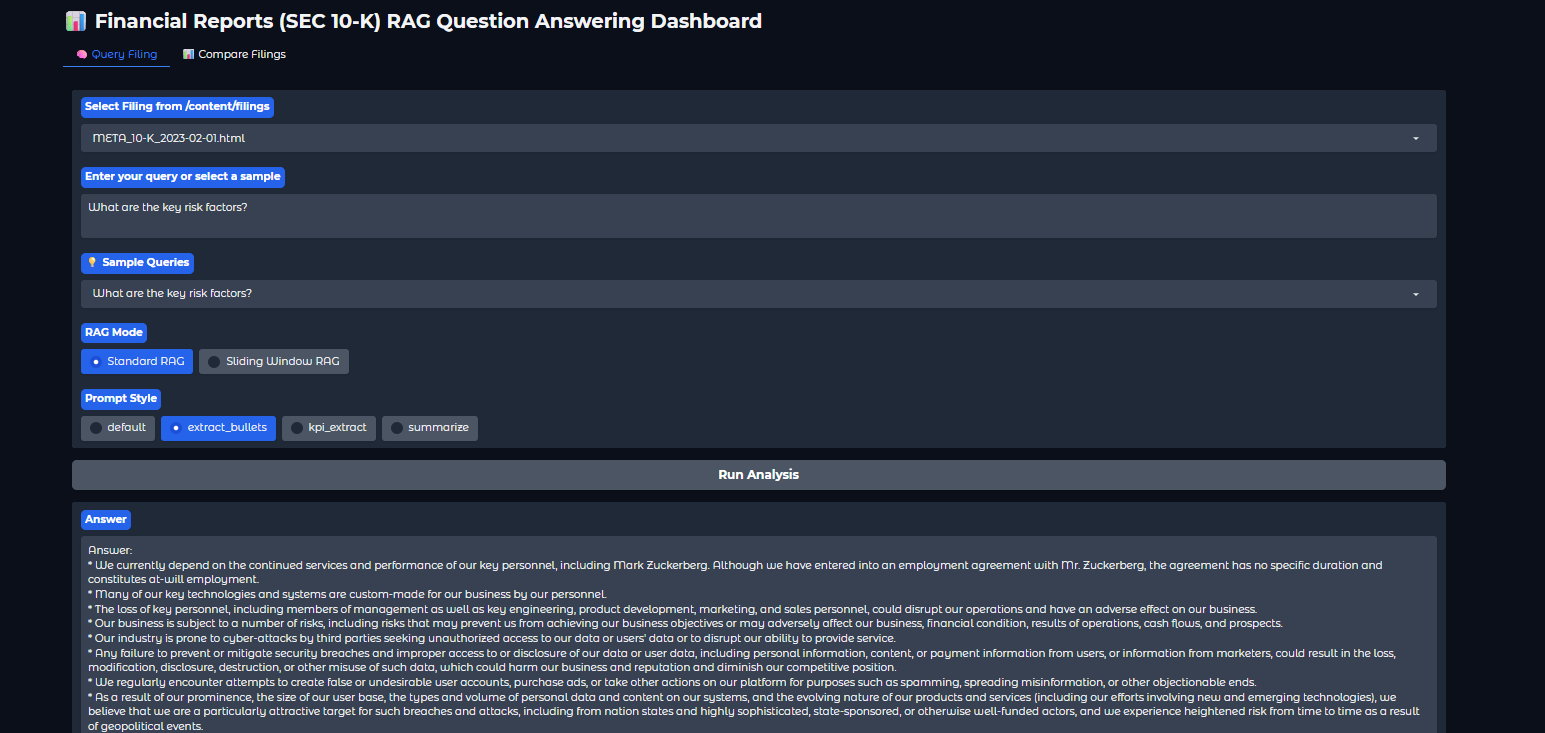
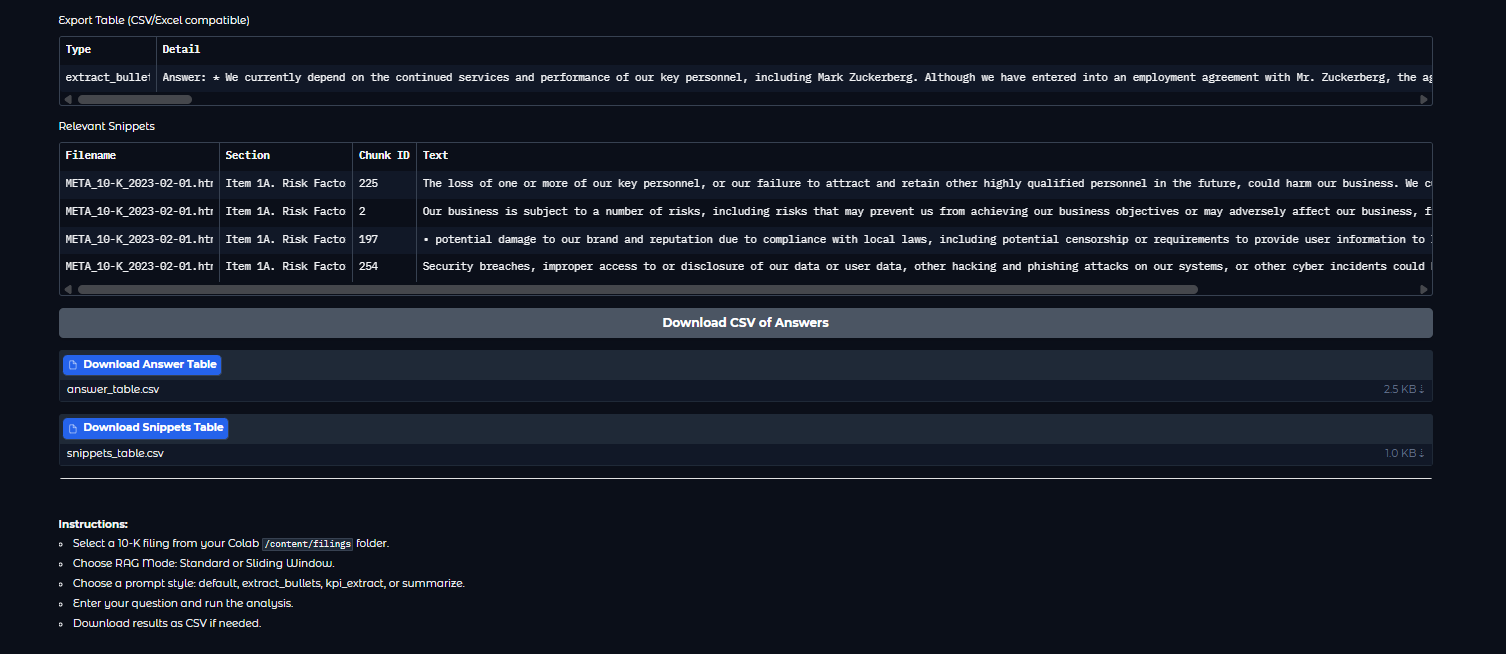

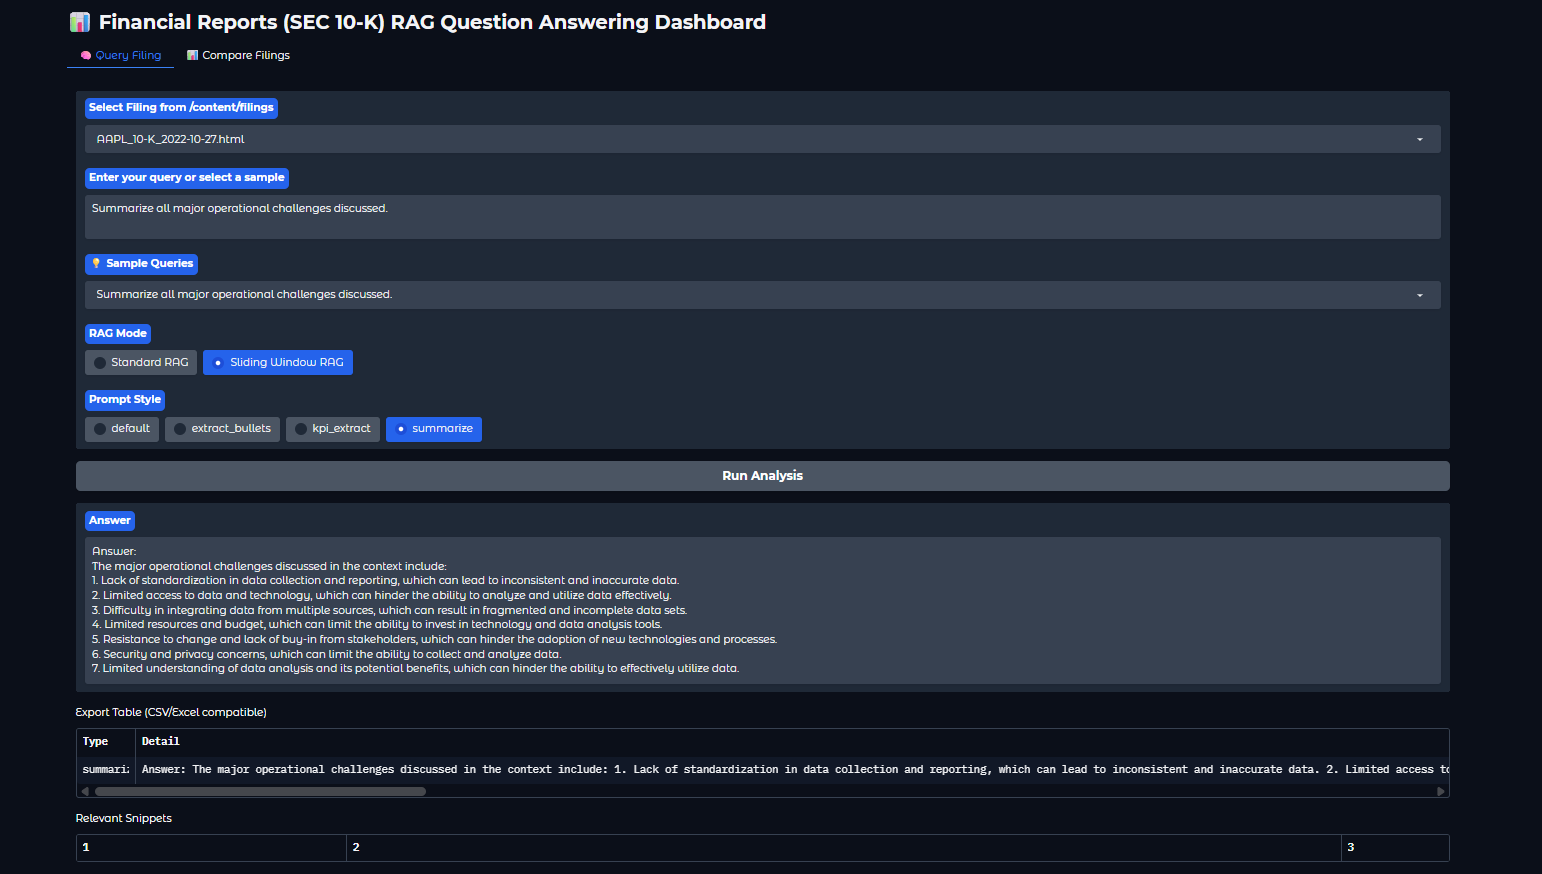

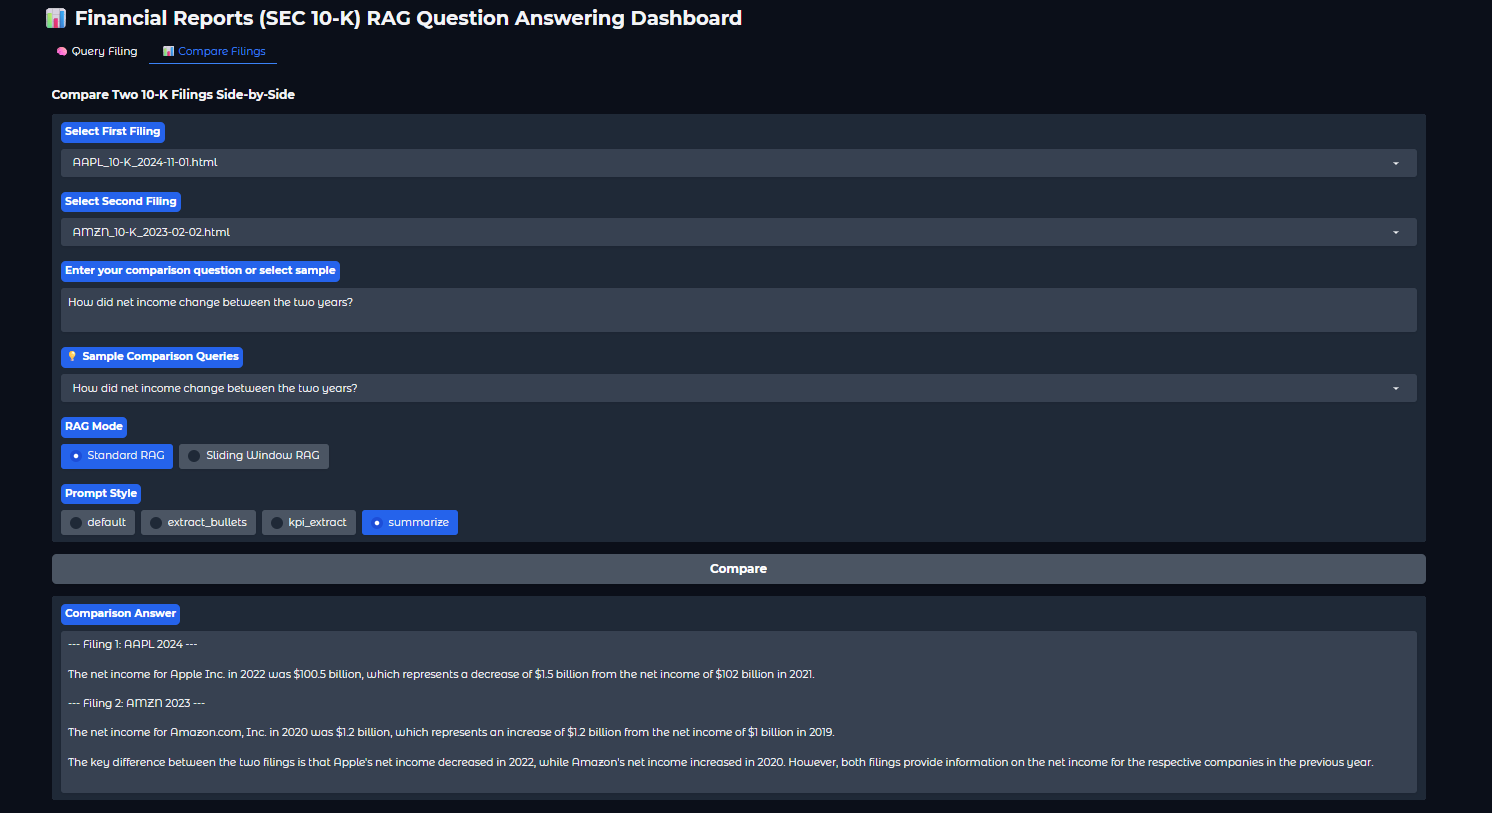
